In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lineagevi
import scanpy as sc
import scvelo as scv
import numpy as np
import os

In [3]:
adata = scv.datasets.pancreas()

In [4]:
adata.X = adata.layers['unspliced'].copy() + adata.layers['spliced'].copy()
adata.layers['counts'] = adata.X.copy()

In [6]:
annotation_path = '/Users/lgolinelli/git/lineageVI/notebooks/data/inputs/gene_sets/'
annotation_name = 'msigdb_development_or_pancreas.gmt'
file_path = os.path.join(annotation_path, annotation_name)
lineagevi.utils.add_annotations(
    adata, 
    files=[file_path],
    min_genes=12,
    varm_key='I',
    uns_key='terms',
    clean=True,
    genes_use_upper=True)

adata._inplace_subset_var(adata.varm['I'].sum(1) > 0)

In [7]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=True, log=True)

Filtered out 8545 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


In [8]:
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps=100)
sc.pp.neighbors(adata, n_neighbors=30)
scv.pp.moments(adata, n_neighbors=30)
sc.pp.scale(adata, layer='Mu')
sc.pp.scale(adata, layer='Ms')

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Filter out any annotations (terms) with less than 12 genes.

In [9]:
select_terms = adata.varm['I'].sum(0)>12
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

Filter out genes not present in any retained terms after selection of HVGs.

In [10]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [11]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=20 + 1, metric='euclidean', n_jobs=-1)
nbrs.fit(adata.obsm['X_pca'])
distances, indices = nbrs.kneighbors(adata.obsm['X_pca'])

adata.uns['indices'] = indices

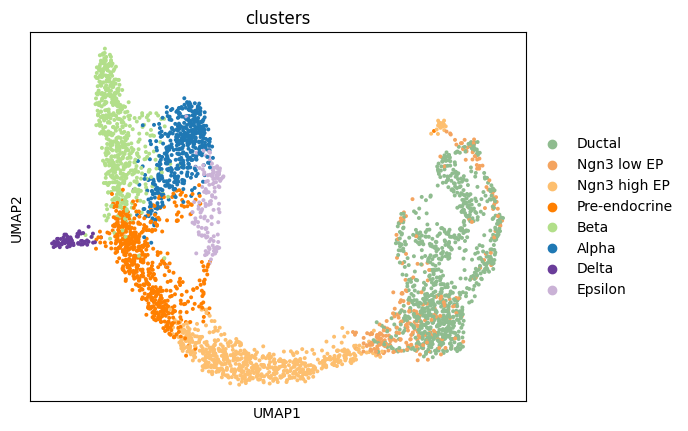

In [12]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='clusters')

In [13]:
vae = lineagevi.LineageVI(
    adata=adata,
    n_hidden=128,
    mask_key='I',
    unspliced_key='Mu',
    spliced_key='Ms',
    latent_key='z',
    nn_key='indices',
)

history = vae.fit(
    K=10,
    batch_size=1024,
    lr=1e-3,
    epochs1=5,
    epochs2=5,
    seeds=(0, 1, 2),
    output_dir='/Users/lgolinelli/git/lineageVI/notebooks/data/outputs/pancreas',   # or None
    verbose=1,
)

[Regime1] Epoch 1/5 - Loss: 3.1173
[Regime1] Epoch 2/5 - Loss: 3.0714
[Regime1] Epoch 3/5 - Loss: 3.0073
[Regime1] Epoch 4/5 - Loss: 2.9175
[Regime1] Epoch 5/5 - Loss: 2.8007
[Regime2] Epoch 1/5 - Velocity Loss: 0.5833
[Regime2] Epoch 2/5 - Velocity Loss: 0.5255
[Regime2] Epoch 3/5 - Velocity Loss: 0.4795
[Regime2] Epoch 4/5 - Velocity Loss: 0.4461
[Regime2] Epoch 5/5 - Velocity Loss: 0.4231
Saved model  → /Users/lgolinelli/git/lineageVI/notebooks/data/outputs/pancreas/vae_velocity_model.pt
Note: Call model.get_model_outputs() to annotate adata with velocities


In [14]:
vae.get_model_outputs(
    adata=adata,
    n_samples=100,
    return_mean=True,
    return_negative_velo=True,
    base_seed=0,
    save_to_adata=True,
    unspliced_key='Mu',
    spliced_key='Ms',
    latent_key='z',
    nn_key='indices'
)

computing velocity graph (using 1/10 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/lgolinelli/miniconda3/envs/test1/lib

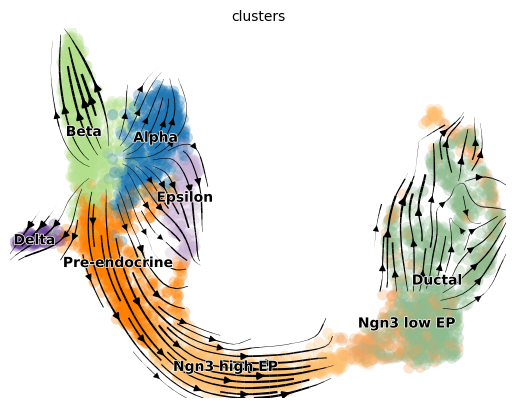

In [15]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color='clusters')

In [16]:
adata_gp = lineagevi.utils.build_gp_adata(
    adata,
    model=vae,
    n_samples=100,
    return_negative_velo=True,
    base_seed=0
)

computing velocity graph (using 1/10 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


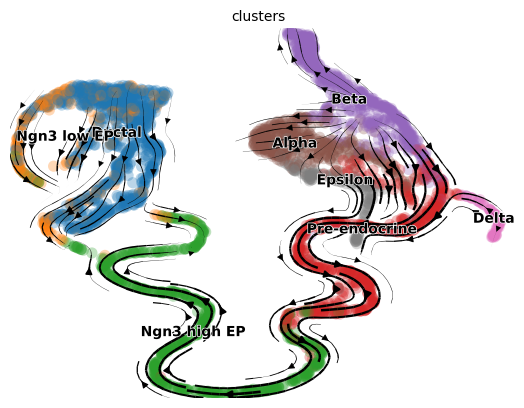

In [17]:
sc.pp.neighbors(adata_gp)
sc.tl.umap(adata_gp)
scv.tl.velocity_graph(adata_gp)
scv.pl.velocity_embedding_stream(adata_gp, color='clusters')

In [ ]:
vae.map_velocities(
        adata,
        adata_gp=None,
        direction = "gp_to_gene",
        scale = 10.0,
        velocity_key = "velocity_gp2gene",
        unspliced_key = "Mu",
        spliced_key = "Ms"
)


/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/tools/velocity_graph.py:114: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(adata)
/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute PCA with Scanpy first.
  _set_pca(adata=adata, n_pcs=n_pcs, use_highly_variable=use_highly_variable)


In [20]:
vae.map_velocities(
        adata,
        adata_gp=adata_gp,
        direction = "gene_to_gp",
        scale = 10.0,
        velocity_key = "velocity_gene2gp",
        unspliced_key = "Mu",
        spliced_key = "Ms"
)

In [ ]:
linvi.map_velocities(
    adata,
    direction="gp_to_gene",
    n_samples=100,
    scale=10.0,
    velocity_key="velocity_gp2gene",
    return_gp_adata=False
)


In [31]:
lineagevi.plots.top_features_table(adata, celltype_key="clusters", categories=['Beta'], layer="velocity", n=10)

,gp,mean_activation,Beta mean
1,Ldlrad4,1.874665,1.874665
2,Slc24a2,1.638363,1.638363
3,Satb1,1.543706,1.543706
4,Slc7a8,1.512566,1.512566
5,Nucb2,1.504473,1.504473
6,Vps8,1.485859,1.485859
7,Ppp2r2b,1.473735,1.473735
8,Cib2,1.456189,1.456189
9,Cdh23,1.454098,1.454098
10,Robo1,1.437284,1.437284


In [37]:
lineagevi.plots.top_features_table(adata_gp, celltype_key="clusters", categories=["Ductal", 'Beta'], layer="velocity", n=10)

,feature,mean_activation,Ductal mean,Beta mean
1,FETAL_PLACENTA_PAEP_MECOM_POSI,0.265371,0.246347,0.294858
2,DN2_VS_DN3_THYMOCYTE_DN,-0.263237,-0.218746,-0.332194
3,UNSTIM_VS_IFNG_STIM_AND_B_BURG-1,-0.234643,-0.305886,-0.124221
4,CTRL_VS_TNFRSF6B_IN_MACROPHAGE-1,0.221723,0.181864,0.283502
5,MUSCLE_CELL_MIGRATION,0.221134,0.167503,0.304256
6,TP53_HRAS_COOPERATION_RESPONSE,-0.199500,-0.155524,-0.267660
7,ADIPOGENESIS_PEAK_AT_0HR,-0.196322,-0.210785,-0.173904
8,BLADDER_CANCER_CLUSTER_2B,-0.195643,-0.204768,-0.181501
9,BOUND_BY_FOXP3_STIMULATED,0.195087,0.132630,0.291891
10,CBFB_KO_VS_WT_TREG_UP,-0.186142,-0.151697,-0.239528


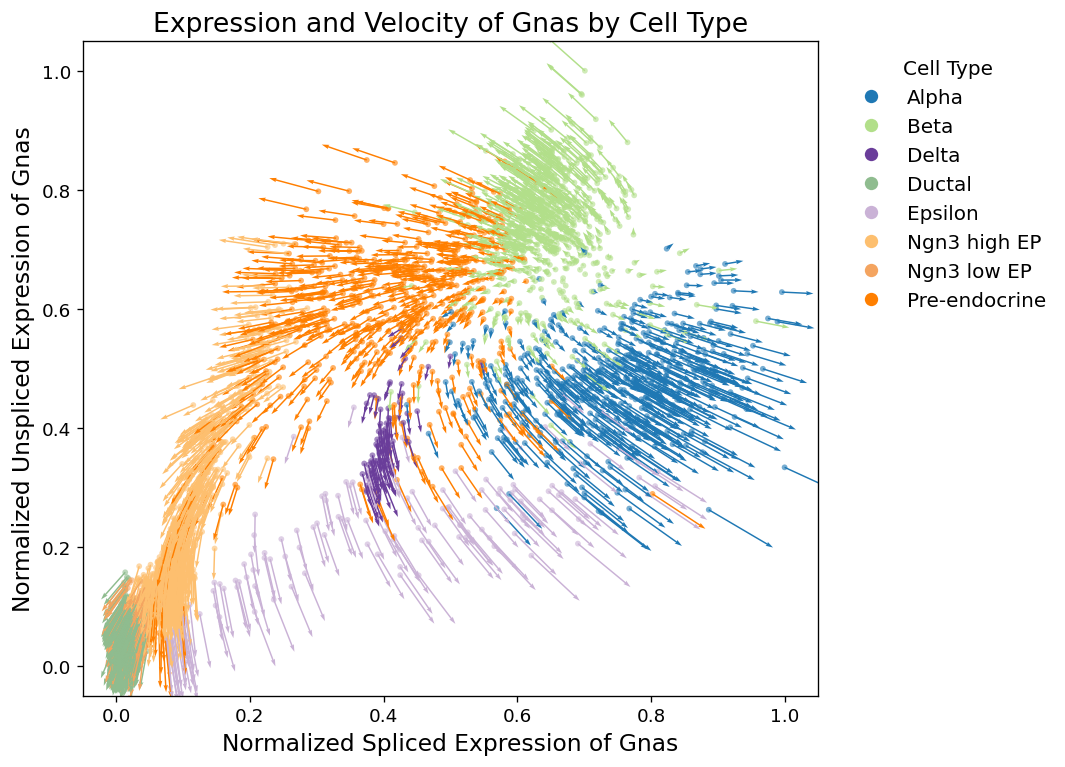

(<Figure size 1080x780 with 1 Axes>,
 <Axes: title={'center': 'Expression and Velocity of Gnas by Cell Type'}, xlabel='Normalized Spliced Expression of Gnas', ylabel='Normalized Unspliced Expression of Gnas'>)

In [36]:
lineagevi.plots.plot_phase_plane(adata, 'Gnas', u_scale=.1, s_scale=.1, alpha=1, head_width=0.02, head_length=0.03, length_includes_head=False)

In [ ]:
sc.pl.violin(adata, keys='Gcg', layer='alpha', groupby='clusters')